# This is a notebook showing the example use case of the erosion and dilation MONAI-compatible dictionary transforms

In [1]:
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy
from monai import transforms as monai_trans
from monai.data import DataLoader,CacheDataset
device = "cuda" if torch.cuda.is_available() else "cpu"

class Error(Exception):
    """Base class for other exceptions"""
    pass

import monai
print('Monai version: ' +str(monai.__version__ ))

Monai version: 1.3.0


## Import the package

In [2]:
from erosion_dilation import BinaryErosiond, BinaryDilationd, GreyDilationd, GreyErosiond

## Sample data from tumour segmentation work, see https://github.com/high-dimensional/tumour-seg

In [3]:
#create a dummy dataset from a single segmentation
paths_enh = sorted(glob.glob('sample_data/*enh*gz'))
paths_nonenh = sorted(glob.glob('sample_data/*net*gz'))
paths_oedema = sorted(glob.glob('sample_data/*oed*gz'))
paths_whole_tumour = sorted(glob.glob('sample_data/*whole_tumour*gz'))
paths_whole_lesion = sorted(glob.glob('sample_data/*whole_lesion*gz'))
paths_segmentation = sorted(glob.glob('sample_data/*MNI*gz'))

files = [{"enhancing_seg":u,'nonenhancing_seg': v, "oedema_seg": w, "whole_tumour": x, "whole_lesion": y, "template": z} for u, v, w, x, y, z in zip(paths_enh,paths_nonenh,paths_oedema,paths_whole_tumour, paths_whole_lesion,paths_segmentation)]
binary_key = ['whole_lesion']
imaging_keys = ['enhancing_seg','nonenhancing_seg','oedema_seg']
# imaging_keys = ['oedema_seg','enhancing_seg','nonenhancing_seg']
all_keys = ['enhancing_seg','nonenhancing_seg','oedema_seg','whole_lesion','whole_tumour','template']
imaging_keys_reversed = imaging_keys
imaging_keys_reversed.reverse()

z=91 #cut point for plotting
template = np.asanyarray(nib.load('sample_data/MNI152_T1_1mm.nii.gz').dataobj)
# template = scipy.ndimage.rotate(template,angle=90)

## Example use in single loader

In [4]:
transforms = [monai_trans.LoadImaged(keys=binary_key,dtype=np.float32)]
transforms += [GreyErosiond(keys=binary_key,prob=1,random_size=True)]
transforms = monai_trans.Compose(transforms)

dataset = CacheDataset(data=files, transform=transforms)
loader = DataLoader(dataset, shuffle=False, batch_size=1, drop_last=False,
                        num_workers=0,pin_memory=False)

for batch in loader:
    print("it's that easy...")

Loading dataset: 100%|██████████████████████████████| 1/1 [00:00<00:00, 27.83it/s]

it's that easy...


## Comprehensive example with varying degrees of erosion and dilation

Loading dataset: 100%|██████████████████████████████| 1/1 [00:00<00:00, 11.30it/s]


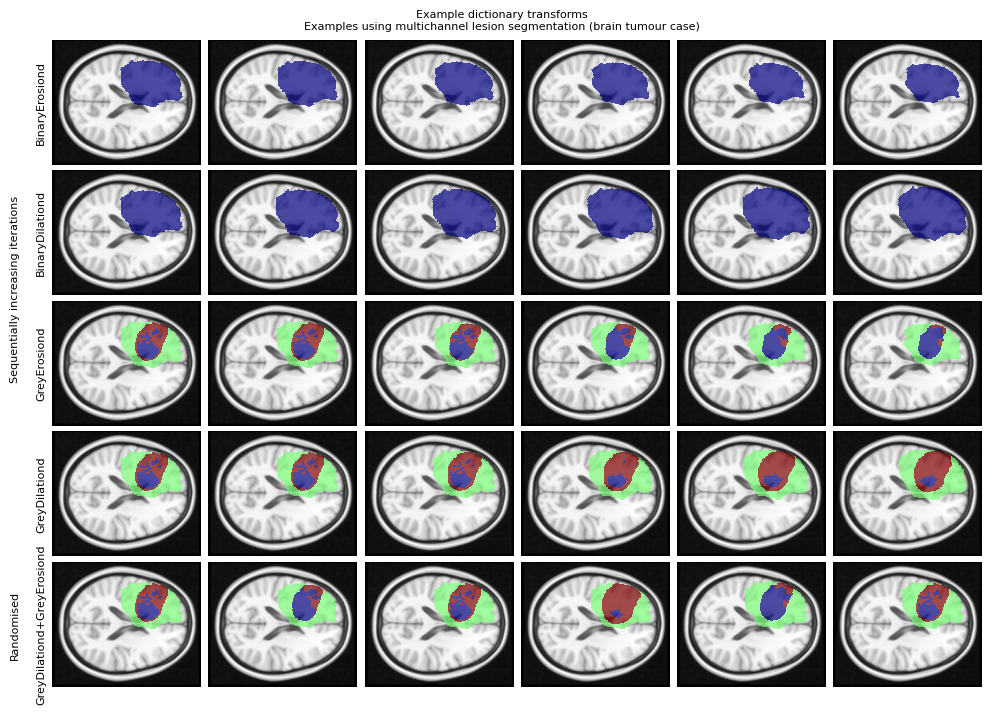

In [5]:
versions = 5
iter_range = 6

fig, axes = plt.subplots(nrows=versions, ncols=iter_range,figsize=(iter_range*2,iter_range*2))

#Plot binary erosion with increasing number of interations across all segmentation channels
version_counter=0
for iteration in range(iter_range):
    transforms = [monai_trans.LoadImaged(keys=binary_key,dtype=np.float32)]
    
    if iteration==0:    
        transforms += [BinaryErosiond(keys=binary_key,vary_across_channels=False,prob=0,random_iteration=False)]
    else:
        transforms += [BinaryErosiond(keys=binary_key,vary_across_channels=False,prob=1,iteration=iteration,random_iteration=False)]
    transforms = monai_trans.Compose(transforms)

    dataset = CacheDataset(data=files, transform=transforms)
    loader = DataLoader(dataset, shuffle=False, batch_size=1, drop_last=False,
                            num_workers=0,pin_memory=False)

    for batch in loader:
        whole_lesion = batch['whole_lesion'].to(device,non_blocking=True)

    input_multichannel = np.zeros(shape=whole_lesion.shape[1:])
    input_multichannel[whole_lesion[0,:,:,:].cpu().numpy().nonzero()]=1 #whole lesion
#     input_multichannel = scipy.ndimage.rotate(input_multichannel,angle=90,order=1)
    input_multichannel_masked = np.ma.masked_where(input_multichannel < 1, input_multichannel)
    axes[version_counter,iteration].imshow(template[:,:,z],cmap='Greys_r')
    axes[version_counter,iteration].imshow(input_multichannel_masked[:,:,z],alpha=0.7,vmin=1,vmax=3,cmap='jet',interpolation='Nearest')

version_counter+=1
#Plot binary dilation with increasing number of interations across all segmentation channels
for iteration in range(iter_range):
    transforms = [monai_trans.LoadImaged(keys=binary_key,dtype=np.float32)]
    if iteration==0:    
        transforms += [BinaryDilationd(keys=binary_key,vary_across_channels=False,prob=0,random_iteration=False)]
    else:
        transforms += [BinaryDilationd(keys=binary_key,vary_across_channels=False,prob=1,iteration=iteration,random_iteration=False)]
    transforms = monai_trans.Compose(transforms)

    dataset = CacheDataset(data=files, transform=transforms)
    loader = DataLoader(dataset, shuffle=False, batch_size=1, drop_last=False,
                            num_workers=0,pin_memory=False)

    for batch in loader:
        whole_lesion = batch['whole_lesion'].to(device,non_blocking=True)

    input_multichannel = np.zeros(shape=whole_lesion.shape[1:])
    input_multichannel[whole_lesion[0,:,:,:].cpu().numpy().nonzero()]=1 #whole lesion
#     input_multichannel = scipy.ndimage.rotate(input_multichannel,angle=90)
    input_multichannel_masked = np.ma.masked_where(input_multichannel < 1, input_multichannel)
    axes[version_counter,iteration].imshow(template[:,:,z],cmap='Greys_r')
    axes[version_counter,iteration].imshow(input_multichannel_masked[:,:,z],alpha=0.7,vmin=1,vmax=3,cmap='jet',interpolation='Nearest')
    
version_counter+=1
#Plot grey erosion with increasing number of interations across all segmentation channels
for iteration in range(iter_range):
    transforms = [monai_trans.LoadImaged(keys=imaging_keys,dtype=np.float32)]
    if iteration==0:    
        transforms += [GreyErosiond(keys=imaging_keys,prob=0,random_size=False,randomize_key_order=False)]
    else:
        transforms += [GreyErosiond(keys=imaging_keys,prob=1,size=iteration,random_size=False,randomize_key_order=False)]
    transforms = monai_trans.Compose(transforms)

    dataset = CacheDataset(data=files, transform=transforms)
    loader = DataLoader(dataset, shuffle=False, batch_size=1, drop_last=False,
                            num_workers=0,pin_memory=False)
    for batch in loader:
        enhancing_seg = batch['enhancing_seg'].to(device,non_blocking=True)
        nonenhancing_seg = batch['nonenhancing_seg'].to(device,non_blocking=True)
        oedema_seg = batch['oedema_seg'].to(device,non_blocking=True)
 
    if len(torch.unique(oedema_seg+nonenhancing_seg+enhancing_seg)[1:])>3:
        raise Error('Co-existent lesion compartments, something has gone wrong...')

    input_multichannel = np.zeros(shape=oedema_seg.shape[1:])
    input_multichannel[enhancing_seg[0,:,:,:].cpu().numpy().nonzero()]=3 #enhancing tumour
    input_multichannel[nonenhancing_seg[0,:,:,:].cpu().numpy().nonzero()]=1 #nonenhancing tumour
    input_multichannel[oedema_seg[0,:,:,:].cpu().numpy().nonzero()]=2 #oedema
#     input_multichannel = scipy.ndimage.rotate(input_multichannel,angle=90)
    input_multichannel_masked = np.ma.masked_where(input_multichannel < 1, input_multichannel)
    
    axes[version_counter,iteration].imshow(template[:,:,z],cmap='Greys_r')
    axes[version_counter,iteration].imshow(input_multichannel_masked[:,:,z],alpha=0.7,vmin=1,vmax=3,cmap='jet',interpolation='Nearest')
    
version_counter+=1
#Plot grey erosion with increasing number of interations across all segmentation channels
for iteration in range(iter_range):
    transforms = [monai_trans.LoadImaged(keys=imaging_keys,dtype=np.float32)]
    if iteration==0:    
        transforms += [GreyDilationd(keys=imaging_keys,prob=0,random_size=False,randomize_key_order=False)]
    else:
        transforms += [GreyDilationd(keys=imaging_keys,prob=1,size=iteration,random_size=False,randomize_key_order=False)]
    transforms = monai_trans.Compose(transforms)

    dataset = CacheDataset(data=files, transform=transforms)
    loader = DataLoader(dataset, shuffle=False, batch_size=1, drop_last=False,
                            num_workers=0,pin_memory=False)
    for batch in loader:
        enhancing_seg = batch['enhancing_seg'].to(device,non_blocking=True)
        nonenhancing_seg = batch['nonenhancing_seg'].to(device,non_blocking=True)
        oedema_seg = batch['oedema_seg'].to(device,non_blocking=True)

    if len(torch.unique(oedema_seg+nonenhancing_seg+enhancing_seg)[1:])>3:
        raise Error('Co-existent lesion compartments, something has gone wrong...')

    input_multichannel = np.zeros(shape=oedema_seg.shape[1:])
    input_multichannel[enhancing_seg[0,:,:,:].cpu().numpy().nonzero()]=3 #enhancing tumour
    input_multichannel[nonenhancing_seg[0,:,:,:].cpu().numpy().nonzero()]=1 #nonenhancing tumour
    input_multichannel[oedema_seg[0,:,:,:].cpu().numpy().nonzero()]=2 #oedema
#     input_multichannel = scipy.ndimage.rotate(input_multichannel,angle=90)
    input_multichannel_masked = np.ma.masked_where(input_multichannel < 1, input_multichannel)
    
    axes[version_counter,iteration].imshow(template[:,:,z],cmap='Greys_r')
    axes[version_counter,iteration].imshow(input_multichannel_masked[:,:,z],alpha=0.7,vmin=1,vmax=3,cmap='jet',interpolation='Nearest')
 
version_counter+=1
#Plot grey dilation and erosion with variable number of interations across all segmentation channels
for iteration in range(iter_range):
    transforms = [monai_trans.LoadImaged(keys=imaging_keys,dtype=np.float32)]
    if iteration==0:    
        transforms += [GreyDilationd(keys=imaging_keys,prob=0,random_size=False)]
    else:
        transforms += [GreyDilationd(keys=imaging_keys,prob=1,random_size=True,randomize_key_order=True, seed=np.random.randint(99))]
        transforms += [GreyErosiond(keys=imaging_keys,prob=1,random_size=True,randomize_key_order=True, seed=np.random.randint(99))]
    transforms = monai_trans.Compose(transforms)

    dataset = CacheDataset(data=files, transform=transforms)
    loader = DataLoader(dataset, shuffle=False, batch_size=1, drop_last=False,
                            num_workers=0,pin_memory=False)
    for batch in loader:
        enhancing_seg = batch['enhancing_seg'].to(device,non_blocking=True)
        nonenhancing_seg = batch['nonenhancing_seg'].to(device,non_blocking=True)
        oedema_seg = batch['oedema_seg'].to(device,non_blocking=True)

    if len(torch.unique(oedema_seg+nonenhancing_seg+enhancing_seg)[1:])>3:
        raise Error('Co-existent lesion compartments, something has gone wrong...')

    input_multichannel = np.zeros(shape=oedema_seg.shape[1:])
    input_multichannel[enhancing_seg[0,:,:,:].cpu().numpy().nonzero()]=3 #enhancing tumour
    input_multichannel[nonenhancing_seg[0,:,:,:].cpu().numpy().nonzero()]=1 #nonenhancing tumour
    input_multichannel[oedema_seg[0,:,:,:].cpu().numpy().nonzero()]=2 #oedema
#     input_multichannel = scipy.ndimage.rotate(input_multichannel,angle=90)
    input_multichannel_masked = np.ma.masked_where(input_multichannel < 1, input_multichannel)
    
    axes[version_counter,iteration].imshow(template[:,:,z],cmap='Greys_r')
    axes[version_counter,iteration].imshow(input_multichannel_masked[:,:,z],alpha=0.7,vmin=1,vmax=3,cmap='jet',interpolation='Nearest')
 
    
for row in axes:
    for col in row:
        col.set_box_aspect(1)
        col.axis('off')

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=-0.675)

plt.text(-0.25,1,'Sequentially increasing iterations',rotation=90,transform=axes[2,0].transAxes,horizontalalignment='center',verticalalignment='center',fontsize=iter_range+2)
plt.text(-0.25,0.5,'Randomised',rotation=90,transform=axes[4,0].transAxes,horizontalalignment='center',verticalalignment='center',fontsize=iter_range+2)

plt.text(-0.075,0.5,'BinaryErosiond',rotation=90,transform=axes[0,0].transAxes,horizontalalignment='center',verticalalignment='center',fontsize=iter_range+2)
plt.text(-0.075,0.5,'BinaryDilationd',rotation=90,transform=axes[1,0].transAxes,horizontalalignment='center',verticalalignment='center',fontsize=iter_range+2)
plt.text(-0.075,0.5,'GreyErosiond',rotation=90,transform=axes[2,0].transAxes,horizontalalignment='center',verticalalignment='center',fontsize=iter_range+2)
plt.text(-0.075,0.5,'GreyDilationd',rotation=90,transform=axes[3,0].transAxes,horizontalalignment='center',verticalalignment='center',fontsize=iter_range+2)
plt.text(-0.075,0.5,'GreyDilationd+GreyErosiond',rotation=90,transform=axes[4,0].transAxes,horizontalalignment='center',verticalalignment='center',fontsize=iter_range+2)

st = plt.suptitle('Example dictionary transforms\nExamples using multichannel lesion segmentation (brain tumour case)', fontsize=iter_range+2)
st.set_y(0.79)

plt.savefig("sample_data/sample_image.png",dpi=600,bbox_inches='tight')